In [9]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import sys
import hippomaps as hm

In [10]:
# config

useCheckpoints=False

micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
tmp_dir = 'tmp_MICs-struct'

subs = [
 'HC048', 'HC043', 'HC087', 'HC037', 'HC055', 'HC100', 'HC036', 'HC017', 'HC088', 'HC040',
 'HC058', 'HC076', 'HC090', 'HC059', 'HC101', 'HC063', 'HC094', 'HC024', 'HC050', 'HC080',
 'HC013', 'HC026', 'HC001', 'HC084', 'HC105', 'HC083', 'HC042', 'HC014', 'HC033', 'HC081',
 'HC106', 'HC108', 'HC095', 'HC002', 'HC102', 'HC028', 'HC020', 'HC049', 'HC007', 'HC023',
 'HC065', 'HC025', 'HC056', 'HC003', 'HC015', 'HC077', 'HC067', 'HC072', 'HC109', 'HC086',
 'HC089', 'HC091', 'HC031', 'HC039', 'HC112', 'HC068', 'HC034', 'HC032', 'HC060', 'HC047',
 'HC103', 'HC046', 'HC009', 'HC097', 'HC116', 'HC053', 'HC079', 'HC029', 'HC075', 'HC078',
 'HC057', 'HC018', 'HC074', 'HC064', 'HC096', 'HC010', 'HC038', 'HC093', 'HC082', 'HC092',
 'HC027', 'HC019', 'HC005', 'HC008', 'HC011', 'HC044', 'HC030', 'HC035', 'HC085', 'HC069',
 'HC041', 'HC012', 'HC054', 'HC022', 'HC016', 'HC099', 'HC073', 'HC052', 'HC045']
ses = 'ses-01'
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
den = '0p5mm'

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# loop through these types of structural images
features = ['DTI-FA', 'DTI-ADC', 'qT1']
file_ext = ['model-DTI_map-FA', 'model-DTI_map-ADC', 'map-T1map']

In [ ]:
if not useCheckpoints:
    !mkdir -p {tmp_dir}
    hipp_dat = np.ones((nV,len(hemis),len(subs),len(features)))*np.nan

    for s,sub in enumerate(subs):
        try:
            for h,hemi in enumerate(hemis):
                for l,label in enumerate(labels):
                    for f,feature in enumerate(features):
                        # sample
                        cmd4 = f'wb_command -volume-to-surface-mapping '\
                            f'{micapipe_dir}/sub-{sub}/{ses}/maps/sub-{sub}_{ses}_space-nativepro_{file_ext[f]}.nii.gz '\
                            f'{hippunfold_dir}/sub-{sub}/{ses}/surf/sub-{sub}_{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                            f'{tmp_dir}/sub-{sub}_{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_{feature}.shape.gii '\
                            f'-enclosing'
                        !{cmd4}
                        d = nib.load(f'{tmp_dir}/sub-{sub}_{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_{feature}.shape.gii')
                        hipp_dat[iV[l],h,s,f] = d.darrays[0].data
        except:
            print(f'{sub} no {feature}')
    np.save("../checkpoints/MRI-3T-struct_unproc",hipp_dat, allow_pickle=True)
    !rm -rf {tmp_dir}

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


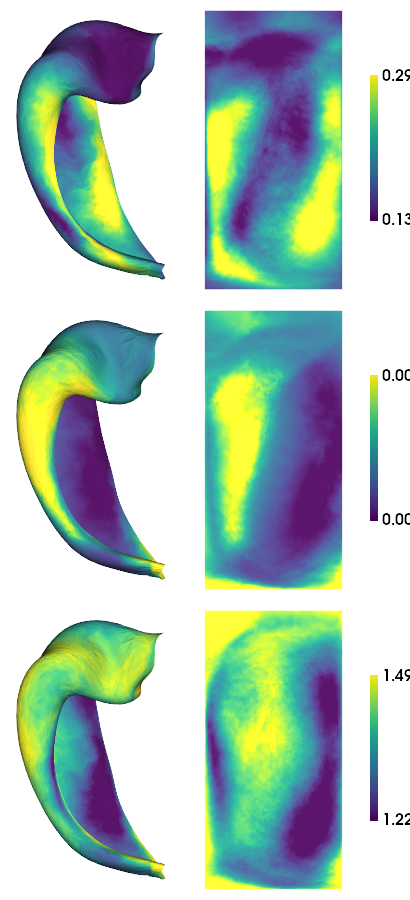

In [17]:
hipp_dat = np.load("../checkpoints/MRI-3T-struct_unproc.npy")
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(hipp_dat,axis=(1,2)), color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

In [19]:
# save 2D map
!mkdir -p ../../maps/HippoMaps-initializationMaps/Dataset-MICs
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for f,feature in enumerate(features):
            cdat = np.nanmean(hipp_dat[iV[l],h,:,f],axis=1).flatten()
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-{feature}_average-{len(subs)}_hemi-{hemi}_den-0p5mm_label-{label}.shape.gii')